# CartPole Using Q-Learning

[CartPole Documentation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.

| Num | Action                 |
|-----|------------------------|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |

**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

**Note:** While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
- The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)


## Q-Learning Table

| Num | Start | Step Width | Steps (Inc. 0) |
|-----|-------|------------|----------------|
| 0   | -2.4  | 0.1        | 48 + 1         |
| 1   | -4    | 0.1       | 80 + 1        |
| 2   | -12   | 1°         | 24 + 1         |
| 3   | -4    | 0.1       | 80 + 1        |


In [2]:
import gym
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


c:\Users\jason\AppData\Local\Continuum\Anaconda3\lib\site-packages\gym\envs\registration.py:423: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  logger.warn(


Text(0, 0.5, 'Score')

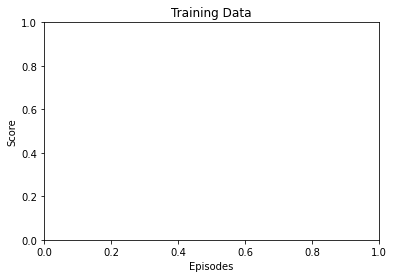

In [3]:
ALPHA = 0.5
GAMMA = 0.9
EPSILON = 1.0
EPSILON_DECAY = 0.99995
EPSILON_MIN = 0.001

REWARD_SHAPING = 1000

EPOCHS = 100
EPISODES = 1000
ENV_NAME = "CartPole-v1"

RANGES = [[-2.4, 2.4], [-4, 4], [-0.2095, 0.2095], [-4, 4]]
# STEPS = (0.1, 0.1, math.radians(1), 0.1)
STEPS = (0.1, 0.2, math.radians(1), 0.2)

Q_LEARNING = "QLEARNING"
SARSA = "SARSA"

plt.title("Training Data")
plt.xlabel("Episodes")
plt.ylabel("Score")

In [4]:
def check_decay_length(epsilon, decay, minimum):
    i = 0

    while epsilon > minimum:
        epsilon *= decay
        i += 1

    return i


def save(model, path):
    with open(path, "wb") as f:
        pickle.dump(model, f)


def load(path):
    with open(path, "rb") as f:
        agent = pickle.load(f)

    print("Epochs:", agent.epochs)
    return agent


In [5]:
check_decay_length(EPSILON, EPSILON_DECAY, EPSILON_MIN)


138152

In [17]:
class QTable:
    def __init__(
        self,
        ranges=RANGES,
        steps=STEPS,
        agent_type=Q_LEARNING,
        alpha=ALPHA,
        gamma=GAMMA,
        env_name=ENV_NAME,
    ):
        """
        :param np_arr q_table: state, state, ... action
        :param float[] start: start values of each observation space
        :param int[] step: distance of each step
        """

        # Using round() instead of int due to floating point error
        shape = [
            round((value_range[1] - value_range[0]) / steps[i]) + 1
            for i, value_range in enumerate(ranges)
        ]

        action_space = gym.make(env_name).action_space.n
        shape.append(action_space)

        shape = tuple(shape)
        self.q_table = np.zeros(shape)

        self.steps = steps
        self.agent_type = agent_type

        self.alpha = alpha
        self.gamma = gamma

    def _discrete(self, state):
        steps = self.steps
        discrete_state = [int(state[i] / steps[i]) for i in range(len(state))]

        return discrete_state

    def _q_func(self, reward, q_current_value, q_forward_value):
        alpha = self.alpha
        gamma = self.gamma

        q_value = q_current_value + alpha * (
            reward + gamma * q_forward_value - q_current_value
        )
        return q_value

    def _get_sub_table(self, state):
        q_sub_table = self.q_table

        discrete_state = self._discrete(state)

        for index in discrete_state:
            q_sub_table = q_sub_table[index]

        return q_sub_table

    def get_value(self, state, action=None):
        q_value = self._get_sub_table(state)

        if action is not None:
            q_value = q_value[action]

        return q_value

    def _update_value(self, state, action, update_value):
        """
        :param float update_value: Value to update table cell with
        """

        q_sub_table = self._get_sub_table(state)

        # * Some real jargony pass-by-reference wizerdry going on here
        # * Essentially, navigate through n-dimensions a long a list of indices and get the final cell reference
        q_sub_table[action] = update_value

    def update_table(self, state, forward_state, action, reward):
        """
        :param int action: Discrete action, or index of best choice in q_table
        """

        agent_type = self.agent_type

        q_current = self.get_value(state, action)
        q_forward = self.get_value(forward_state)
        if agent_type == Q_LEARNING:
            q_forward = np.max(q_forward)
        else:
            q_forward = np.average(q_forward)

        update_value = self._q_func(reward, q_current, q_forward)
        self._update_value(state, action, update_value)


In [7]:
q = QTable(RANGES, STEPS)
q.q_table.shape


(49, 41, 25, 41, 2)

In [8]:
print(int((2.4 - -2.4) / 0.1 + 1))
print(round((2.4 - -2.4) / 0.1 + 1))


48
49


In [9]:
print(q._discrete([0, 0, 0, 0]))
print(q._discrete([0.1, -0.2, math.radians(-11), -0.4]))


[0, 0, 0, 0]
[1, -1, -11, -2]


In [10]:
state = [0.1, -0.2, math.radians(-11), -0.4]
q.get_value(state)

array([0., 0.])

In [11]:
q.update_table([0.1, -0.2, math.radians(-11), -0.4], [0.1, -0.2, math.radians(-12), -0.4], 0, 1000)

In [12]:
q_flat = q.q_table.flatten()

for cell in q_flat: 
    if cell != 0:
        print(cell)

500.0


In [25]:
class QAgent:
    def __init__(
        self,
        agent_type=Q_LEARNING,
        env_name=ENV_NAME,
        epsilon_decay=EPSILON_DECAY,
        epsilon_min=EPSILON_MIN,
        ranges=RANGES,
        steps=STEPS,
    ):
        env = gym.make(env_name)
        env.seed(0)

        self.env = env

        self.rewards = []
        self.epoch_rewards = []
        self.epochs = 0

        self.q_table = QTable(
            ranges=ranges, steps=steps, agent_type=agent_type, env_name=env_name
        )
        self.epsilon = EPSILON
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.agent_type = agent_type

    def evaluate(self, episodes=EPISODES, render=False):
        rewards = self.rewards
        q_table = self.q_table
        epsilon = self.epsilon

        env = self.env

        for _ in range(episodes):
            state = env.reset()
            score = 1
            done = False

            while not done:
                if render:
                    env.render()

                if np.random.rand() > epsilon or render:
                    action = np.argmax(q_table.get_value(state))
                else:
                    action = env.action_space.sample()

                forward_state, reward, done, _ = env.step(action)

                score += reward

                if done:
                    # if score == 200:
                    # self.evaluate(episodes=1, render=True)
                    # score = REWARD_SHAPING

                    break

                q_table.update_table(state, forward_state, action, reward)

                state = forward_state

            rewards.append(score)

            epsilon *= self.epsilon_decay
            epsilon = max(self.epsilon_min, epsilon)

        self.epsilon = epsilon

    def train(self, episodes=EPISODES, epochs=EPOCHS):
        epoch_rewards = self.epoch_rewards

        for i in range(epochs):
            self.evaluate(episodes)

            self.epochs += 1
            epoch_reward = round(np.mean(self.rewards[-episodes:]))
            epoch_rewards.append(epoch_reward)

            clear_output(wait=True)
            print(
                "Agent:",
                self.agent_type,
                "\t| Epoch: ",
                self.epochs,
                "\t| Avg. Reward: ",
                epoch_reward,
            )
            self.display()

    def display(self):
        plt.plot(self.rewards)
        plt.show()


In [14]:
q_agent = QAgent()

c:\Users\jason\AppData\Local\Continuum\Anaconda3\lib\site-packages\gym\core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [15]:
print(check_decay_length(EPSILON, 0.99997, EPSILON_MIN))
sarsa_agent = QAgent(agent_type="SARSA", epsilon_decay=0.9997)
sarsa_agent.q_table.q_table.shape

230256


(49, 41, 25, 41, 2)

Agent: QLEARNING 	| Epoch:  150 	| Avg. Reward:  141


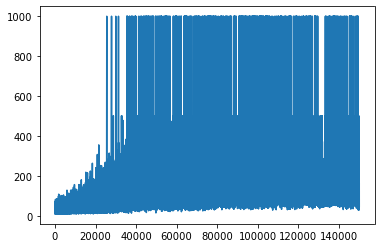

In [21]:
q_agent.train(epochs=50)
save(q_agent, "ql_cartpole.bin")

Agent: SARSA 	| Epoch:  125 	| Avg. Reward:  134


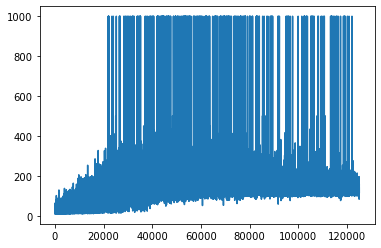

In [16]:
sarsa_agent.train(epochs=24)


In [17]:
len(sarsa_agent.rewards)

101000

In [17]:
save(sarsa_agent, "sarsa_cartpole_125.bin")

In [25]:
q_agent = load("ql_cartpole_150.bin")

Epochs: 150


In [29]:
q_agent.evaluate(episodes=1, render=True)

In [20]:
sarsa_agent = load("sarsa_cartpole_125.bin")
len(sarsa_agent.rewards)

Epochs: 125


125000

In [24]:
sarsa_agent.evaluate(episodes=1, render=True)

## Mountain Car


In [16]:
ENV_NAME = "MountainCar-v0"

RANGES = [[-10, 10], [-10, 10]]
STEPS = (1, 1)

In [26]:
q_agent = QAgent(env_name=ENV_NAME, ranges=RANGES, steps=STEPS)
q_agent.q_table.q_table.shape

c:\Users\jason\AppData\Local\Continuum\Anaconda3\lib\site-packages\gym\core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


(21, 21, 3)

Agent: QLEARNING 	| Epoch:  5 	| Avg. Reward:  -199


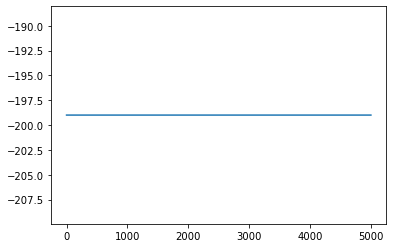

KeyboardInterrupt: 

In [27]:
q_agent.train(epochs=50)
